# Data Loading and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/all-data.csv',
                 encoding='unicode_escape',
                 names=['Sentiment', 'Text'])
print(df.shape)
print('\n'*3)
df.head()

(4846, 2)






,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.drop_duplicates(subset=['Text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4838 non-null   object
 1   Text       4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


<Axes: xlabel='Sentiment'>

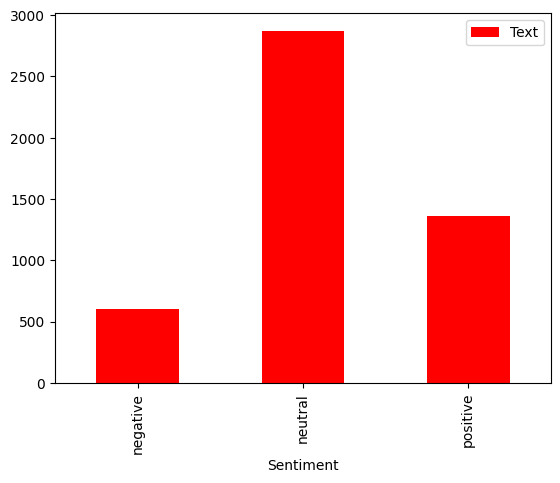

In [ ]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'red')

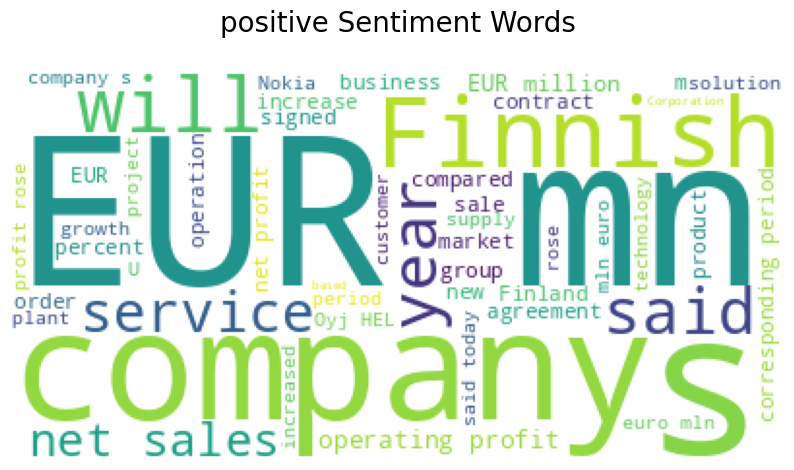

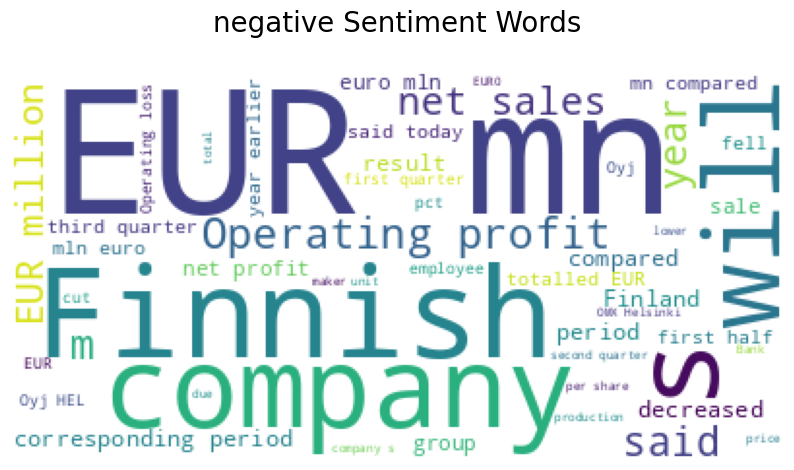

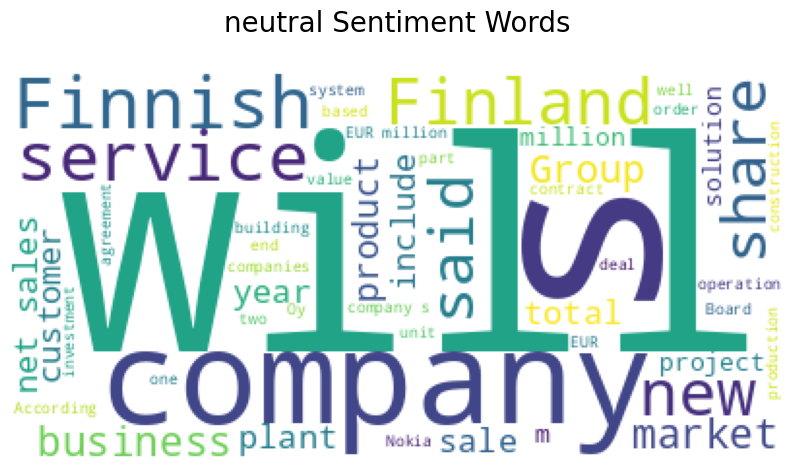

In [ ]:
def wordcount_gen(df, category):

    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment == category]['Text']])

    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words\n'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

wordcount_gen(df, 'positive')

wordcount_gen(df, 'negative')

wordcount_gen(df, 'neutral')

In [ ]:
example = df['Text'][10]
print(example)

TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Telekom 's offering to its customers .


# ProsusAI/finbert Model

In [ ]:
X = df['Text'].to_list()
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [ ]:
df['predicted_finbert'] = preds

In [ ]:
df

In [ ]:
y = df['Sentiment'].tolist()

def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

evaluate_model_accuracy('ProsusAI/finbert', preds)

Model: ProsusAI/finbert - Accuracy-Score: 0.8892


# Model Evaluation Metrics

In [ ]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

In [ ]:
evaluate_model_accuracy('ProsusAI/finbert', preds)

Model: ProsusAI/finbert - Accuracy-Score: 0.8892


In [ ]:
print(classification_report(y,preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2872
    positive       0.81      0.92      0.86      1362

    accuracy                           0.89      4838
   macro avg       0.86      0.92      0.88      4838
weighted avg       0.90      0.89      0.89      4838



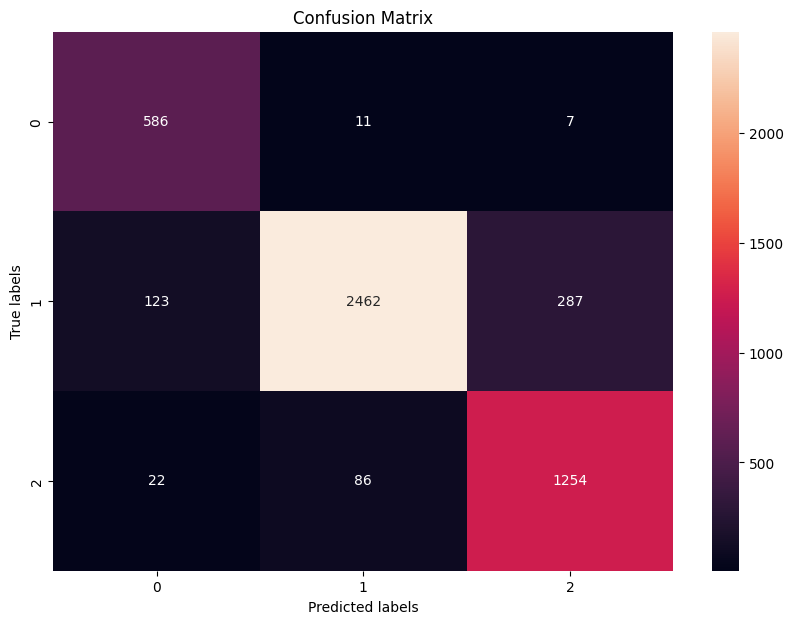

In [ ]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()